<a href="https://colab.research.google.com/github/salmacmpeg/Satelite-Image-semantic-Segmentation/blob/main/Dstl_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#this version is the reduced 4 classes +background version , works on t_masks_2 and folders end with 2
#............................................
#Authors: 
# salma abdel Monem Abdel Motaleb
#..............................................
#this code is used after the preprocessing step.
#after the preprocessing the images and their masks are saved in two arrays t_images and t_masks.
#these two arrays are saved as binary files , exported and uploaded here.

#imports
!pip install image_slicer
!pip install tifffile
!pip install python-resize-image
!pip install keras_segmentation
import tensorflow as tf
from collections import defaultdict
import csv
import sys
import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import pandas as pd
import image_slicer
from resizeimage import resizeimage
from PIL import Image
import pickle
from google.colab import drive
import os
import random
import re
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras_segmentation.models.unet import vgg_unet
from keras_segmentation.models.segnet import resnet50_segnet 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import time
from keras import optimizers
from keras_segmentation.models.fcn import fcn_32 
import matplotlib.pyplot as plt
tf.test.gpu_device_name()

     |████████████████████████████████| 133kB 4.8MB/s 
     |████████████████████████████████| 18.1MB 197kB/s 
     |████████████████████████████████| 3.3MB 6.6MB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-cp36-none-any.whl size=29072 sha256=ea02cb83dfde7d899e67aaba01a98879c5fcbe397665b007d7d2403fb6156cd1
  Stored in directory: /root/.cache/pip/wheels/d0/bb/c0/6aad88b38f6e46db048bed4cccb904a5897055a8ab6fbd4dfc
Successfully built keras-segmentation
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1


Using TensorFlow backend.


'/device:GPU:0'

In [ ]:
#mount the drive to load the data
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive//Colab Notebooks/Satellite_Segmentation
!ls


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/Satellite_Segmentation
frames3			  test_masks3	 validation_frames2
masks2			  t_images_2	 validation_frames3
masks3			  t_masks_2	 validation_masks2
seg_v1_Abdelrahman.ipynb  t_masks_3	 validation_masks3
seg_v1.ipynb		  train_frames2  vgg_unet_red_ADAM_noaug_8batch.h5
test_frames2		  train_frames3  vgg_unet_red_SGD_aug_8batch.h5
test_frames3		  train_masks2	 vgg_unet_red_SGD_noaug_16batch.h5
test_masks2		  train_masks3

In [ ]:
DATA_PATH=Data_Dir='/content/gdrive/My Drive/Colab Notebooks/Satellite_Segmentation'
Num_Classes=5

In [ ]:
#colors for each class
#we have 7 classes shown below
#sorted from 0 to 6
#we will use this colormap for visualization after segmentation
background=[255,255,255]
building=[100,50,100]
water=[50,60,200]
road=[200,130,50]
track=[255,255,100]
trees=[20,120,80]
crops=[30,230,150]
water2=[50,50,150]
#oldcolor_map=[{0:background},{1:building},{2:water},{3:road},{4:track},{5:trees},{6:crops},{7:water2}]
color_map=[{0:background},{1:building},{2:water},{3:road},{4:crops},{5:trees},{6:track},{7:water2}]

In [ ]:
#load the original images and masks frame(before splitting) and after the preprocessing is done
def load_original():
  with open(Data_Dir+'/t_images_2', 'rb') as f:
      images = pickle.load(f)
  with open(Data_Dir+'/t_masks_2', 'rb') as f:
      masks = pickle.load(f)
  #now let's merge the water classes (2 and 7) to be 2 only
  new_mask=[]
  for item in masks:
    item=np.where(item==7, 2, item) #move water2 to water
    item=np.where(item==6, 5, item) #move crops to trees
    item=np.where(item==4, 3, item) #move track to road
    item=np.where(item==5, 4, item) #move crops and trees to be in 4
    new_mask.append(item)
  print(np.unique(new_mask[24]))
    #now we have 5 classes including the background {background, building, water, road,crops}
  return images,new_mask

In [ ]:
#this function divides the original image of size (3348,3348) to (num_slices*num_slices) smaller images
def slicing_image(image_size,images,num_slices,mask=False):
    new_images=[]
    for im in images:
        #im3 scaled to 0 to 255 and resized to the image size
        if mask==True:
          im3 = cv2.resize((im), image_size, interpolation = cv2.INTER_AREA)
          bsize=int(image_size[0]/num_slices)
          for i in range(num_slices):
              for j in range(num_slices):
                  x0,y0,x1,y1 = (i*bsize, j*bsize, (i+1)*bsize, (j+1)*bsize) 
                  new_images.append(im3[x0:x1,y0:y1])
        else:
          im3 = cv2.resize(scale_percentile(im), image_size, interpolation = cv2.INTER_AREA)
          bsize=int(image_size[0]/num_slices)
          for i in range(num_slices):
              for j in range(num_slices):
                  x0,y0,x1,y1 = (i*bsize, j*bsize, (i+1)*bsize, (j+1)*bsize) 
                  new_images.append(im3[x0:x1,y0:y1,:])
    return new_images

In [ ]:
#this cell is from https://www.kaggle.com/lopuhin/full-pipeline-demo-poly-pixels-ml-poly
def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return (matrix*255).astype(np.uint8)

In [ ]:
#caller for the slicing function on the frames and the masks
def images_splitting(num_slices,images,new_mask):
  #image_size=[3348,3348]
  image_size=(3348,3348)
  new_images=slicing_image(image_size,images,num_slices,mask=False)
  new_masks=slicing_image(image_size,new_mask,num_slices,mask=True) 
  bsize=int(image_size[0]/num_slices)
  print("smaller image size: ", bsize)
  print("number of new images: ",len(new_images))
  return new_images,new_masks

In [ ]:
#dont rerun this
#saves the new smaller sized images in the frames and masks directories
def save_smaller_images(new_images,new_masks):
  Frames_PATH=Data_Dir+'/frames3'
  for i in range(len(new_images)):
    j=0
    #cv2.imwrite(Frames_PATH+'/{}'.format(i)+'.png',new_images[i])
    
  Masks_PATH=Data_Dir+'/masks2'
  for i in range(len(new_masks)):
    #cv2.imwrite(Masks_PATH+'/{}'.format(i)+'.png',new_masks[i])
    j=0
    

In [ ]:
#dont rerun this
#splits and saves the new smaller sized images from the frames and masks directories to the train, test and validation directories
#this cell is from https://towardsdatascience.com/a-keras-pipeline-for-image-segmentation-part-1-6515a421157d
DATA_PATH = Data_Dir
FRAME_PATH = DATA_PATH+'/frames3/'
MASK_PATH = DATA_PATH+'/masks2/'
def add_frames(dir_name, image):
    img=cv2.imread(FRAME_PATH+image)
    #cv2.imwrite(DATA_PATH+'/{}'.format(dir_name)+'/'+image,img)
    
def add_masks(dir_name, image):
    img=cv2.imread(MASK_PATH+image)
    #cv2.imwrite(DATA_PATH+'/{}'.format(dir_name)+'/'+image,img)
   

def save_train_validation_test():
  DATA_PATH = Data_Dir
  FRAME_PATH = DATA_PATH+'/frames3/'
  MASK_PATH = DATA_PATH+'/masks2/'
  folders = ['train_frames2', 'train_masks2', 'validation_frames2', 'validation_masks2', 'test_frames2', 'test_masks2']
  # Get all frames and masks, sort them, shuffle them to generate data sets.
  all_frames = os.listdir(FRAME_PATH)
  all_masks = os.listdir(MASK_PATH)
  all_frames.sort(key=lambda var:[int(x) if x.isdigit() else x 
                                  for x in re.findall(r'[^0-9]|[0-9]+', var)])
  all_masks.sort(key=lambda var:[int(x) if x.isdigit() else x 
                                for x in re.findall(r'[^0-9]|[0-9]+', var)])
  random.seed(230)
  random.shuffle(all_frames)
  # Generate train, val, and test sets for frames
  train_split = int(0.7*len(all_frames))
  val_split = int(0.9 * len(all_frames))

  train_frames = all_frames[:train_split]
  val_frames = all_frames[train_split:val_split]
  test_frames = all_frames[val_split:]

  # Generate corresponding mask lists for masks
  train_masks = [f for f in all_masks if f in train_frames]
  test_masks = [f for f in all_masks if f in test_frames]
  val_masks = [f for f in all_masks if f in val_frames]
  #Add train, val, test frames and masks to relevant folders

  frame_folders = [(train_frames, 'train_frames2'), (val_frames, 'validation_frames2'), 
                  (test_frames, 'test_frames2')]

  mask_folders = [(train_masks, 'train_masks2'), (val_masks, 'validation_masks2'), 
                  (test_masks, 'test_masks2')]
  #saving the frames
  for folder in frame_folders:
    array = folder[0]
    name = [folder[1]] * len(array)
    print('saving folder',folder[1])
    list(map(add_frames, name, array))
    print('done saving ',len(folder[0]))
  #saving the masks
  for folder in mask_folders:
    array = folder[0]
    name = [folder[1]] * len(array)
    print('saving folder',folder[1])
    list(map(add_masks, name, array))
    print('done saving ',len(folder[0]))


In [ ]:
#view percentage of every class in the masks
#the classes are unbalanced :(
def view_distribution(new_masks):
  perc=np.zeros(Num_Classes)
  total=0
  copy_mask=new_masks
  for item in copy_mask:
    item=np.array(item)
    total+=item.shape[0]*item.shape[1]
    for index in range(Num_Classes):
      perc[index]+=np.count_nonzero(item == index)
  avg=[peri / total for peri in perc]
  print(avg)
  plt.scatter(range(Num_Classes),avg)

In [ ]:
#plots the accuracy and the loss after the model is trained
#this cell is from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
def print_statistics(m):
  print(m.history.history.keys())
  plt.plot(m.history.history['accuracy'])
  plt.plot(m.history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(m.history.history['loss'])
  plt.plot(m.history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
#prints the Intersection of union for each class in the predected test set
def evaluate_test(m):
  ev=m.evaluate_segmentation( inp_images_dir=DATA_PATH+'/test_frames2'  , annotations_dir=DATA_PATH+'/test_masks2'  )
  print(ev)


In [ ]:
#this function converts a segmented mask to the according colormap
def view_seg(image):
  w,h=image.shape
  n_image=np.zeros((w,h,3))
  for layer in range(n_image.shape[2]):
    n_image[:,:,layer]=image
    for index in range(len(color_map)):
      for key in color_map[index]:
        n_image[:,:,layer]=np.where(n_image[:,:,layer]==key, color_map[index][key][layer], n_image[:,:,layer])
  return n_image

In [ ]:
#predict and show one segmented image
#example image='/test_frames/1568.png'
def pred_and_show(m,image='/test_frames2/1568.png'):
  out = m.predict_segmentation(
      inp=DATA_PATH+image,
      out_fname="/tmp/out.png"
  )
  out2=view_seg(out)
  out2=out2.astype(np.uint8)
  plt.imshow(out2)
  return out2

In [ ]:
#this train function calls  models implemeted in the keras_segmentation library
#add more models and optimizers
#returns the model after training and saving
def train_model(DATA_PATH,model_name,epochs,batch_size,optimizer_name,optimizer_lr,optimizer_mom,save_name):
  if model_name=='vgg_unet':
    m = vgg_unet(n_classes=Num_Classes ,  input_height=416, input_width=416  )
  elif model_name=='resnet50_segnet':
    m=resnet50_segnet(n_classes=Num_Classes ,  input_height=416, input_width=416  )
  elif model_name=='fcn_32':
    m=fcn_32(n_classes=Num_Classes ,  input_height=416, input_width=416  )
  elif model_name=='unet':
    m=unet(n_classes=Num_Classes ,  input_height=416, input_width=416  )
  elif model_name== 'resnet50_unet':
    m=resnet50_unet(n_classes=Num_Classes ,  input_height=416, input_width=416 )
  elif model_name== 'segnet':
    m=segnet(n_classes=Num_Classes ,  input_height=416, input_width=416 )
  elif model_name== 'resnet50_segnet':
    m=resnet50_segnet(n_classes=Num_Classes ,  input_height=416, input_width=416 )
  elif model_name== 'fcn_8':
    m=fcn_8(n_classes=Num_Classes ,  input_height=416, input_width=416 )
  elif model_name== 'fcn_8_resnet50':
    m=fcn_8_resnet50(n_classes=Num_Classes ,  input_height=416, input_width=416 )
  else:
    print('invalid model name ')
    return
  if optimizer_name=='SGD':
    opt = optimizers.SGD(lr=optimizer_lr, decay=1e-6, momentum=optimizer_mom, nesterov=True)
  else:
    opt='adadelta'
  start_train_time = time.time()
  hist =m.train(
    train_images =  DATA_PATH+'/train_frames2',
    train_annotations = DATA_PATH+'/train_masks2',
    #checkpoints_path = DATA_PATH+'/vgg_unet_save_point' ,
    epochs=epochs,
    validate=True,
    val_images=DATA_PATH+'/validation_frames2',
    val_annotations=DATA_PATH+'/validation_masks2',
    auto_resume_checkpoint=False,
    do_augment=False,
    batch_size=batch_size,
    val_batch_size=batch_size,
    steps_per_epoch=8,
    val_steps_per_epoch=3,
    gen_use_multiprocessing=True,
    optimizer_name=opt
  )
  end_train_time=time.time()
  print("--- %s train time in seconds ---" % (end_train_time - start_train_time))
  m.summary()
  print('saving model')
  m.save((DATA_PATH+"/"+save_name+".h5"))
  return m


[0.5560327579454594, 0.03484318855421096, 0.006663454603407875, 0.03579812240882824, 0.3666624764880935]
Verifying training dataset



100%|██████████| 1120/1120 [00:11<00:00, 94.35it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

Dataset verified! 
Verifying validation dataset



100%|██████████| 320/320 [00:03<00:00, 98.49it/s]


Dataset verified! 
Epoch 1/30


ResourceExhaustedError: ignored

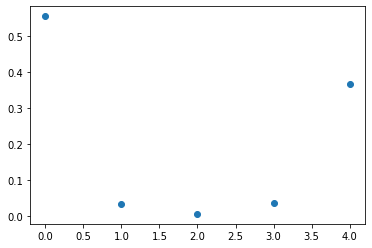

In [ ]:
#images loading takes sometime when running for the first time
#distribution of classes [0.5560327579454594, 0.03484318855421096, 0.006663454603407875, 0.03579812240882824, 0.3666624764880935]
#def main():
  from keras_segmentation.models.unet import unet
  from keras_segmentation.models.unet import resnet50_unet
  from keras_segmentation.models.segnet import segnet,resnet50_segnet
  from keras_segmentation.models.fcn import fcn_8,fcn_8_resnet50
  #images,masks=load_original()
  view_distribution(masks)
  num_slices=8
  new_images,new_masks=images_splitting(num_slices,images,masks)
  save_smaller_images(new_images,new_masks)
  save_train_validation_test()
  DATA_PATH='/content/gdrive/My Drive/Colab Notebooks/Satellite_Segmentation'
  #examples:
  #m2=train_model(DATA_PATH,model_name='unet',epochs=100,batch_size=16,optimizer_name='SGD',optimizer_lr=0.01,optimizer_mom=0.9,save_name='unet_red_SGD_noaug_16batch')
  #m3=train_model(DATA_PATH,model_name='resnet50_unet',epochs=50,batch_size=8,optimizer_name='SGD',optimizer_lr=0.01,optimizer_mom=0.9,save_name='resnet50_unet_red_SGD_noaug_8batch_50epoch')
  #m4=train_model(DATA_PATH,model_name='segnet',epochs=50,batch_size=16,optimizer_name='SGD',optimizer_lr=0.01,optimizer_mom=0.9,save_name='segnet_red_SGD_noaug_8batch_50epoch')
  #m6=train_model(DATA_PATH,model_name='resnet50_segnet',epochs=100,batch_size=8,optimizer_name='SGD',optimizer_lr=0.01,optimizer_mom=0.9,save_name='resnet50_segnet_red_SGD_noaug_8_2batch_100epoch')
  #m7=train_model(DATA_PATH,model_name='resnet50_segnet',epochs=100,batch_size=8,optimizer_name='adadelta',optimizer_lr=0.01,optimizer_mom=0.9,save_name='resnet50_segnet_red_ADAM_noaug_8_2batch_100epoch')
  #m8=train_model(DATA_PATH,model_name='resnet50_segnet',epochs=100,batch_size=8,optimizer_name='adadelta',optimizer_lr=0.01,optimizer_mom=0.9,save_name='resnet50_segnet_red_ADAM_noaug_8_2batch_100epoch')
  m9=train_model(DATA_PATH,model_name='fcn_8',epochs=30,batch_size=8,optimizer_name='adadelta',optimizer_lr=0.01,optimizer_mom=0.9,save_name='fcn_8_red_adadelta_noaugbatch_30epoch')
  print_statistics(m9)
  evaluate_test(m9)
  pred_and_show(m9,image='/test_frames3/1405.png')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [200, 130,  50],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

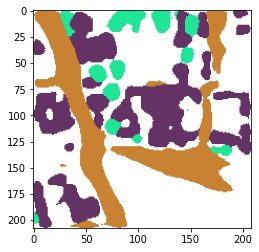

In [ ]:
pred_and_show(m6,image='/test_frames3/111.png')

In [ ]:
#main()